# PDEFIND Feature Overview

This notebook provides a simple overview of the PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614.)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

In [2]:
# Build the energy-preserving quadratic nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    

# Make the projection tensors used for the algorithm
def make_Ptensor(r):
    N = int((r ** 2 + 3 * r) / 2.0)

    # delta_{il}delta_{jk}
    PL_tensor = np.zeros((r, r, r, N))
    PL_tensor_unsym = np.zeros((r, r, r, N))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(N):
                    if i == l and j == k:
                        PL_tensor_unsym[i, j, k, l] = 1.0

    # Now symmetrize PL
    for i in range(r):
        for j in range(N):
            PL_tensor[:, :, i, j] = 0.5 * (PL_tensor_unsym[:, :, i, j] + PL_tensor_unsym[:, :, i, j].T)

    # if j == k, delta_{il}delta_{N-r+j,n}
    # if j != k, delta_{il}delta_{r+j+k-1,n}
    PQ_tensor = np.zeros((r, r, r, r, N))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(r):
                    for n in range(N):
                        if (j == k) and (n == N - r + j) and (i == l):
                            PQ_tensor[i, j, k, l, n] = 1.0
                        if (j != k) and (n == r + j + k - 1) and (i == l):
                            PQ_tensor[i, j, k, l, n] = 1.0 / 2.0
        
    return PL_tensor_unsym, PL_tensor, PQ_tensor

# Variant of Algorithm 2 from Rudy et al. (2017) 
Algorithm 2 is implemented here for scanning the thresholds passed to any of the optimizers. Note that Rudy's Algorithm 2 can be found in the supplementary materials.

In [3]:
# Algorithm to scan over threshold values and select
# highest performing model on the test set
def rudy_algorithm2(x_train, xdot_train, x_test, pde_lib, dtol=1e-2, alpha=1e-5, tol_iter=25, 
                    normalize_columns=False, optimizer_max_iter=100, kappa=1e-3, 
                    ensemble=False, optimization='STLSQ', feature_names=['q']):
    print(optimization)
    # Compute initial model with least-squares
    optimizer = ps.STLSQ(threshold=0, alpha=0, max_iter=optimizer_max_iter, 
                         normalize_columns=normalize_columns)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=feature_names)
    model.fit(x_train, x_dot=xdot_train, ensemble=ensemble)

    # Setup tensors for constrained optimizers (only appropriate for fluid flow ODEs!)
#     n_targets = x_train.shape[1]
#     PL_tensor_unsym, PL_tensor, PQ_tensor = make_Ptensor(n_targets)
#     constraint_zeros, constraint_matrix = make_constraints(n_targets)
    
    # Set the L0 penalty based on the condition number of Theta
    l0_penalty = kappa * np.linalg.cond(optimizer.Theta)
    coef_best = optimizer.coef_
    error_best = model.score(x_test, metric=mean_squared_error, squared=False
                            ) + l0_penalty * np.count_nonzero(coef_best)
    coef_history_ = np.zeros((coef_best.shape[0], coef_best.shape[1], 1 + tol_iter))
    error_history_ = np.zeros(1 + tol_iter)
    coef_history_[:, :, 0] = coef_best
    error_history_[0] = error_best
    tol = dtol
    if optimization[:3] != "SSR" and optimization != "FROLS" and optimization != "Ridge":
        # Loop over threshold values
        for i in range(tol_iter):
            print(tol)
            if optimization == "STLSQ":
                optimizer = ps.STLSQ(threshold=tol, alpha=alpha, max_iter=optimizer_max_iter,
                          normalize_columns=normalize_columns, ridge_kw={'tol': 1e-10})
            elif optimization == "SR3_l0":
                optimizer = ps.SR3(threshold=tol, max_iter=optimizer_max_iter,
                                   normalize_columns=normalize_columns,
                                   thresholder='l0')
            elif optimization == "SR3_l1":
                optimizer = ps.SR3(threshold=tol, max_iter=optimizer_max_iter,
                                   normalize_columns=normalize_columns,
                                   thresholder='l1')
            # Only appropriate for fluid flow ODEs!
#             elif optimizer == "ConstrainedSR3":
#                 optimizer = ps.ConstrainedSR3(threshold=tol, max_iter=optimizer_max_iter,
#                                               normalize_columns=normalize_columns,
#                                               constraint_lhs=constraint_matrix,
#                                               constraint_rhs=constraint_zeros,
#                                               constraint_order="feature")   
#             elif optimizer == "TrappingSR3":
#                 eta = 1.0e-2
#                 alpha_m = 5e-2 * eta
#                 alpha_A = 1.0 * eta
#                 optimizer = ps.TrappingSR3(threshold=tol, eta=eta, alpha_m=alpha_m,
#                                            alpha_A=alpha_A, max_iter=optimizer_max_iter,
#                                            constraint_lhs=constraint_matrix,
#                                            constraint_rhs=constraint_zeros,
#                                            constraint_order="feature")
            elif optimization == "Lasso":
                optimizer = Lasso(alpha=tol, max_iter=optimizer_max_iter)
            elif optimization == "ElasticNet":
                if tol < alpha:
                    optimizer = ElasticNet(alpha=tol, l1_ratio=0.0, max_iter=optimizer_max_iter)
                else:
                    optimizer = ElasticNet(alpha=tol, l1_ratio=(tol - alpha) / tol, max_iter=optimizer_max_iter)
            model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=feature_names)
            model.fit(x_train, x_dot=xdot_train, ensemble=ensemble)
            coef_new = optimizer.coef_
            coef_history_[:, :, i + 1] = coef_new
            error_new = model.score(x_test, metric=mean_squared_error, squared=False
                                    ) + l0_penalty * np.count_nonzero(coef_new)
            error_history_[i + 1] = error_new
            # If error improves, set the new best coefficients
            if error_new <= error_best:
                error_best = error_new
                coef_best = coef_new
                tol += dtol
            else:
                tol = max(0, tol - 2 * dtol)
                dtol = 2 * dtol / (tol_iter - i)
                tol += dtol
    elif optimization == "Ridge":
        for i in range(tol_iter):
            optimizer = Ridge(alpha=alpha, max_iter=optimizer_max_iter)
            model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=feature_names)
            model.fit(x_train, x_dot=xdot_train, ensemble=ensemble)
            coef_new = optimizer.coef_
            coef_history_[:, :, i + 1] = coef_new
            error_new = model.score(x_test, metric=mean_squared_error, squared=False
                                    ) + l0_penalty * np.count_nonzero(coef_new)
            error_history_[i + 1] = error_new
            # If error improves, set the new best coefficients
            if error_new <= error_best:
                error_best = error_new
                coef_best = coef_new
                alpha += dtol
            else:
                alpha = max(0, alpha - 2 * dtol)
                dtol = 2 * dtol / (tol_iter - i)
                alpha += dtol
    else:
        if optimization == "SSR1":
            optimizer = ps.SSR(normalize_columns=normalize_columns)
        elif optimization == "SSR2":
            optimizer = ps.SSR(normalize_columns=normalize_columns, criteria="model_residual")
        elif optimization == "FROLS":
            optimizer = ps.FROLS(normalize_columns=normalize_columns)
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=feature_names)
        model.fit(x_train, x_dot=xdot_train, ensemble=ensemble)
        model_coefs = np.asarray(optimizer.history_)
        for i in range(model_coefs.shape[0]):
            coef_new = model_coefs[i, :, :]
            optimizer.coefs_ = coef_new
            error_new = model.score(x_test, metric=mean_squared_error, squared=False
                                ) + l0_penalty * np.count_nonzero(coef_new)
            error_history_[i + 1] = error_new
            # If error improves, set the new best coefficients
            if error_new <= error_best:
                error_best = error_new
                coef_best = coef_new
    return coef_best, error_best, coef_history_, error_history_

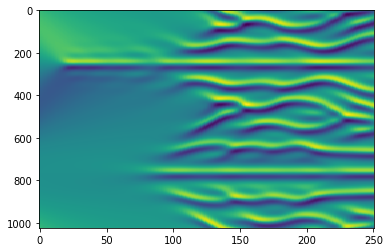

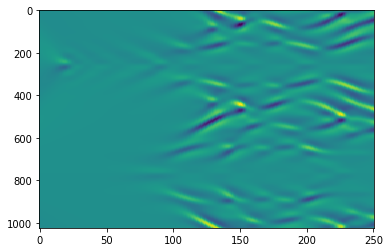

In [4]:
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
# Add noise
#u += np.random.normal(0, 0.001, u.shape)
dt = t[1] - t[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    ut[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(ut[:, :, 0], aspect='auto')

In [5]:
# Usually, randomly assign 60% of time points to training and remainder to testing
# But for the plot later we want to just use the first 60% of the data 

#train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
train = range(0, int(len(t) * 0.6))
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1))

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, 
                        include_bias=True, is_uniform=True)

# Loop through all the optimizers, looping through hyperparams lambda
# and, for the greedy algorithms, kappa. 
coef_lasso, err_lasso, coef_lasso_history, err_lasso_history = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib,
                                        optimization="Lasso")
coef_ridge, err_ridge = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib, dtol=1e-2, 
                                        optimization="Ridge")[:2]
coef_elastic, err_elastic = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib,
                                        optimization="ElasticNet")[:2]
coef_stlsq, err_stlsq = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib, 
                                        optimization="STLSQ")[:2]
coef_sr3_l0, err_sr3_l0 = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib, 
                                        optimization="SR3_l0")[:2]
coef_sr3_l1, err_sr3_l1 = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib, 
                                        optimization="SR3_l1")[:2]
# coef_csr3, err_csr3 = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
#                                         u_test_flattened, pde_lib, dtol=1e-5, 
#                                         optimization="ConstrainedSR3")[:2]
# coef_tsr3, err_tsr3 = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
#                                         u_test_flattened, pde_lib, dtol=1e-5, 
#                                         optimization="TrappingSR3")[:2]
coef_ssr1, err_ssr1 = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib, 
                                        optimization="SSR1")[:2]
coef_ssr2, err_ssr2 = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib, 
                                        optimization="SSR2")[:2]
coef_frols, err_frols, coef_frols_history, err_frols_history = rudy_algorithm2(u_train_flattened, ut_train_flattened, 
                                        u_test_flattened, pde_lib,
                                        optimization="FROLS")[:2]

Lasso
0.01
0.02
0.03
0.04
0.02090909090909091
0.019177489177489175
0.019012987012987013
0.018996582365003418
0.01899486088959773
0.018994670276404023
0.018994647938920386
0.018994645159144646
0.018994644790398887
0.018994644738032626
0.018994644730032227
0.018994644728709847
0.01899464472847182
0.0189946447284248
0.018994644728414518
0.018994644728412
0.018994644728411298
0.018994644728411073
0.01899464472841099
0.01899464472841095
0.01899464472841093
Ridge
ElasticNet
0.01
0.02
0.03
0.04
0.02090909090909091
0.019177489177489175
0.019012987012987013
0.018996582365003418
0.01899486088959773
0.018994670276404023
0.018994647938920386
0.018994645159144646
0.018994644790398887
0.018994644738032626
0.018994644730032227
0.018994644728709847
0.01899464472847182
0.0189946447284248
0.018994644728414518
0.018994644728412
0.018994644728411298
0.018994644728411073
0.01899464472841099
0.01899464472841095
0.01899464472841093
STLSQ
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
print(err_lasso_history)

In [ ]:
# Make fancy plot comparing coefficients
# Plot each optimizer results for the coefficients + error bars
model = ps.SINDy(feature_library=pde_lib, feature_names=['q'])
model.fit(u_train_flattened, x_dot=ut_train_flattened, t=dt)
features = model.get_feature_names()
n_features = len(features)
n_targets = u_train_flattened.shape[-1]
colors = ['b', 'r', 'k']
plt.figure(figsize=(18, 6))
opt_names = ['Lasso', 'Ridge', 'ElasticNet', 'STLSQ', 'SR3 L0', 'SR3 L1', 'SSR1', 'SSR2', 'FROLS']
opt_coef_list = np.asarray([coef_lasso, coef_ridge, coef_elastic, coef_stlsq, 
                 coef_sr3_l0, coef_sr3_l1, coef_ssr1, coef_ssr2, coef_frols])
print(opt_coef_list[0].shape)
for i in range(opt_coef_list.shape[0]):
    #plt.subplot(opt_coef_list.shape[0], 1, i + 1)
    plt.plot(range(n_features), np.ravel(np.abs(opt_coef_list[i])), 'o', label=opt_names[i]) #, color=colors[i])
    ax = plt.gca()
    ax.set_xticks(range(n_features))
    feature_copy = np.copy(features)
    xticknames = []
    for j in range(n_features):
        temp = feature_copy[j].replace('1111', '{xxxx}')
        temp = temp.replace('_111', '_{xxx}')
        temp = temp.replace('11', '{xx}')
        temp = temp.replace('1', '{x}')
        #xticknames[j] = xticknames[j].replace('qqq', 'q^2q')
        xticknames.append(r'$' + temp + '$')
    ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=16)
    plt.grid(True)
    #plt.ylim(-5, 25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #if i != 0 and i != 3 and i != 6:
    #    ax.set_yticklabels([])
    if i != opt_coef_list.shape[0] - 1:
        ax.set_xticklabels([])
    plt.legend(fontsize=18)
plt.savefig('optimizer_PDE_bestmodels_summary.pdf')

In [ ]:
opt_coef_list[8, 0, :]

In [ ]:
np.ravel(coef_ssr2)